# Instancia de librarias

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# import datetime as dt
from datetime import datetime # Trabajar con fechas

# Metricas de desempeño de modelos 
import scipy.stats as stats
import statistics
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler  # Estandarización de los datos
from sklearn.model_selection import cross_val_score

# Series de tiempo
# from statsmodels.tsa.seasonal import seasonal_decompose # graficas de estacionalidad y tendencia
# from statsmodels.tsa.stattools import adfuller # prueba 
# from statsmodels.tsa.statespace.sarimax import SARIMAX #SARIMAX
# import pmdarima as pm # autoarima
# import statsmodels.formula.api as smf

# Prophet

# !pip3 install more-itertools --user
# !pip install prophet --user
import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly

# Formato de visualización por centenas
pd.options.display.float_format = '{:,.2f}'.format

# Graficas
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set_theme(color_codes=True)

# Tamaño del cuadro de las gráficas por defult
plt.rcParams["figure.figsize"] = (12,6)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("Setup complete")

Setup complete


In [2]:
prophet . __version__

# Importación de datos

In [4]:
path = r'E:\\skillsForIndustry/project_wallmart/data/Walmart_Store_sales.csv'
wall_data = pd.read_csv(path, header=0, encoding='utf-8')

In [5]:
wall_data['Date'] = pd.to_datetime(wall_data['Date'],format="%d-%m-%Y",dayfirst=True)
wall_data.info()
wall_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11
4,1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11


#### Frecuencia de tiempo

In [6]:
# Periodos de tiempo
# stores.Date = pd.PeriodIndex(stores.Date, freq='Y')
# stores.Date = pd.PeriodIndex(stores.Date, freq='d')
# stores.Date = pd.PeriodIndex(stores.Date, freq='q')
# stores.Date = pd.PeriodIndex(stores.Date, freq='w')


# Mensual con frecuencia
# stores = wall_data
# stores = stores.iloc[:,[1,0,2]]
# stores.Date = pd.PeriodIndex(stores.Date, freq='M')
# # stores = stores.groupby(['Date'])['Weekly_Sales'].aggregate([sum,min,'mean','count']).reset_index()
# stores = stores.groupby(['Date','Store'])['Weekly_Sales'].mean().reset_index()
# stores['Date'] = stores['Date'].astype(str)
# stores['Store'] = stores.Store.astype(str)
# stores['Date'] =pd.to_datetime(stores['Date'])
# stores.head()

# Mensual sin frecuencia 
# stores = wall_data
# stores = stores.iloc[:,[1,0,2]]
# stores['year'] = pd.DatetimeIndex(stores['Date']).year
# stores['month'] = pd.DatetimeIndex(stores['Date']).month
# stores= stores.groupby(['year','month','Store'])[['Weekly_Sales']].mean().reset_index()
# stores['year_str']=stores.year.apply(str)
# stores['month_str']=stores.month.apply(str)
# stores['Store'] = stores.Store.astype(str)
# stores['year_month'] = stores[['year_str','month_str']].apply('-'.join,axis=1)
# stores['Date']=pd.to_datetime(stores['year_month'],format="%Y-%m",yearfirst=True)
# stores = stores.iloc[:,[7,2,3]]
# stores.head()


# Semanal
stores = wall_data
stores = stores.iloc[:,[1,0,2]]
# stores
# stores.Date = pd.PeriodIndex(stores.Date, freq='w')
# stores = stores.groupby(['Date','Store'])['Weekly_Sales'].sum().reset_index()
# stores['Date'] = stores['Date'].astype(str)
stores['Store'] = stores.Store.astype(str)
# stores[['sb','be']] = stores['Date'].str.split(pat='/',expand=True)
# stores = stores.iloc[:,[3,1,2]]
# stores.columns = ['Date','Store','Weekly_Sales']
stores['Date'] =  stores['Date'] =pd.to_datetime(stores['Date'])
stores.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          6435 non-null   datetime64[ns]
 1   Store         6435 non-null   object        
 2   Weekly_Sales  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 150.9+ KB


In [7]:
num_store = stores['Store'].unique()
num_store

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45'],
      dtype=object)

In [8]:
# for i in num_store:
#     df = stores[stores['store']==i]
#     print(frame)
mes = {}
for store in num_store:
    df = stores[stores['Store']==store].copy()
    df.drop('Store',axis=1, inplace=True)
    mes[store] = df
    df.columns = ['ds','y']
   
# Elegir una tienda    
# mes['20']

In [9]:
# mes['20']

#### Performance

In [10]:
def performance(a,b):
    print('Mean Absolute Error: ',metrics.mean_absolute_error(a,b))
    print('Mean Square Error: ',metrics.mean_squared_error(a,b))
    print('Root Mean Square Error: ',np.sqrt(metrics.mean_squared_error(a,b)))
    print('Mean Absolute Percentage Error: ', metrics.mean_absolute_percentage_error(a,b))
    
    plt.figure(figsize=(10,8),dpi=60)
    sns.regplot(b,a);

# def cross_validation(model,a,b):
#     cv = cross_val_score(model,a,b,cv=10,scoring='r2')
#     print(f'Cross validation: {cv.mean()*100}%')

#### ADF

In [11]:
# def adf(series,column_name):
#     print(f'Resultados ADF: ,{column_name}')
#     dftest = adfuller(series, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used', 'Observation number'])
#     for key, value in dftest[4].items():
#         dfoutput['Critical Values (%s)'%key] = value
#     print(dfoutput)
#     if ((dftest[1] > 0.00) & (dftest[1] <= 0.05)):
#         print('Los datos son estacionarios')
#     else:
#         print('Los datos no son estacionarios')

#### Diferencias

In [12]:
# def dif(st):
#     prev_values = st.ds.shift()
#     dif = st.ds - prev_values
#     dif.plot()

#### Estacionalidad

In [13]:
# def estacionalidad(st):
#     est = seasonal_decompose(st.iloc[1:],model='additive',period = 12)
#     est.plot();

#### Conjunto de entrenamiento y test

In [78]:
def tra_tes(st):
    train = st.sort_values('ds')[:len(st)-12]  # primero datos
    test = st.sort_values('ds')[len(st)-12:]   # últimos datos 
    return train,test

## Mensual

In [15]:
m_20 =  mes['20'].rename_axis(index=None,columns=None)
m_14 =  mes['14'].rename_axis(index=None,columns=None) # No son datos estacionarios
m_5 =  mes['5'].rename_axis(index=None,columns=None)

## Prophet

In [16]:
m_20.head()

,ds,y
2717,2010-02-05,"2,401,395.47"
2718,2010-02-12,"2,109,107.90"
2719,2010-02-19,"2,161,549.76"
2720,2010-02-26,"1,898,193.95"
2721,2010-03-05,"2,119,213.72"


In [17]:
m = Prophet(interval_width= 0.95)
m.fit(m_20)
# training_run = m.fit(m_20)

16:42:53 - cmdstanpy - INFO - Chain [1] start processing
16:42:53 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Mensual
future = m.make_future_dataframe(periods=80, freq='W-FRI')

# Diario
# future = m.make_future_dataframe(periods=390, freq='D')

In [19]:
future.tail()

,ds
218,2014-04-11
219,2014-04-18
220,2014-04-25
221,2014-05-02
222,2014-05-09


In [20]:
forecast = m.predict(future)

In [21]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
218,2014-04-11,"2,241,887.95","1,888,634.54","2,597,698.00","2,239,384.56","2,244,204.42","-6,438.95","-6,438.95","-6,438.95","-6,438.95","-6,438.95","-6,438.95",0.00,0.00,0.00,"2,235,449.00"
219,2014-04-18,"2,242,684.69","1,863,591.44","2,534,403.52","2,240,156.30","2,245,038.72","-39,635.76","-39,635.76","-39,635.76","-39,635.76","-39,635.76","-39,635.76",0.00,0.00,0.00,"2,203,048.94"
220,2014-04-25,"2,243,481.43","1,775,723.64","2,474,188.27","2,240,934.93","2,245,890.01","-109,392.99","-109,392.99","-109,392.99","-109,392.99","-109,392.99","-109,392.99",0.00,0.00,0.00,"2,134,088.45"
221,2014-05-02,"2,244,278.17","1,757,624.53","2,454,187.81","2,241,652.05","2,246,733.22","-148,377.98","-148,377.98","-148,377.98","-148,377.98","-148,377.98","-148,377.98",0.00,0.00,0.00,"2,095,900.19"
222,2014-05-09,"2,245,074.91","1,786,014.35","2,476,771.95","2,242,404.31","2,247,573.50","-120,631.28","-120,631.28","-120,631.28","-120,631.28","-120,631.28","-120,631.28",0.00,0.00,0.00,"2,124,443.63"


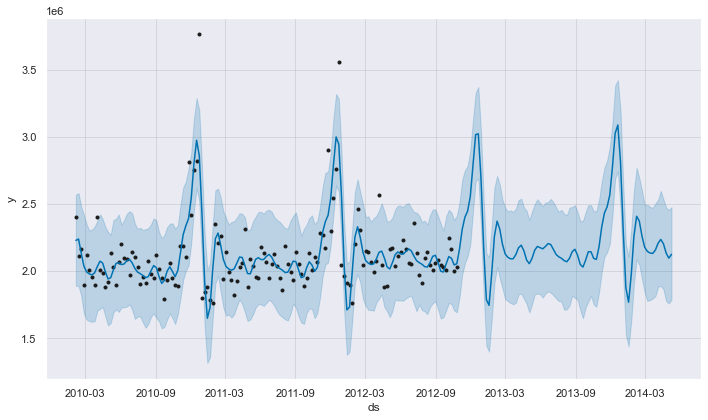

In [22]:
plot = m.plot(forecast)

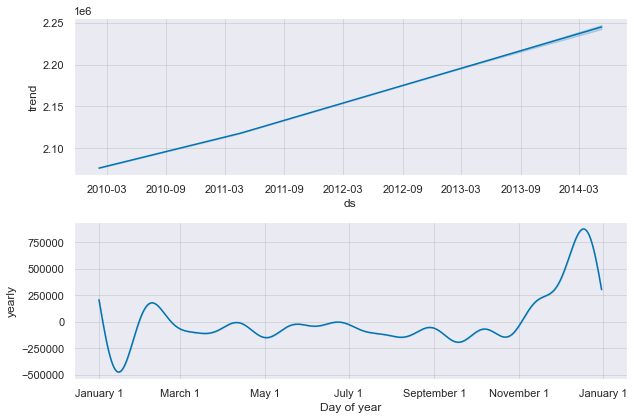

In [23]:
plot2 = m.plot_components(forecast)

#### Con Entrenamiento y Test

In [103]:
train, test = tra_tes(m_20)
# train, test = tra_tes(m_14)
# train, test = tra_tes(m_5)

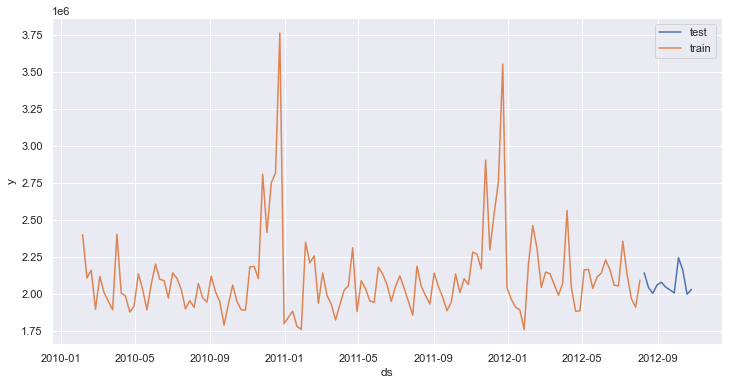

In [80]:
sns.lineplot(data=test, x = 'ds',y ='y', label='test');
sns.lineplot(data=train, x = 'ds',y ='y', label='train');

##### Intanciar al modelo y entrenarlo

In [104]:
m = Prophet(interval_width=0.95, changepoint_prior_scale=0.0001, yearly_seasonality=20)

# Pasandole toda la data
# m.fit(m_20)
# m.fit(m_14)
# m.fit(m_5)

# Pasandole test o train
m.fit(train)
# m.fit(test)

16:57:51 - cmdstanpy - INFO - Chain [1] start processing
16:57:51 - cmdstanpy - INFO - Chain [1] done processing
16:57:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
16:57:51 - cmdstanpy - INFO - Chain [1] start processing
16:57:55 - cmdstanpy - INFO - Chain [1] done processing


In [105]:
# Construir futuro
future = m.make_future_dataframe(periods=12, freq='W-FRI')

# Hacer predicciones
pp = m.predict(future)
pp.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
138,2012-09-28,"2,160,913.65","1,787,045.86","2,047,643.37","2,160,913.64","2,160,913.65","-241,483.75","-241,483.75","-241,483.75","-241,483.75","-241,483.75","-241,483.75",0.00,0.00,0.00,"1,919,429.89"
139,2012-10-05,"2,161,493.68","2,014,391.37","2,270,342.19","2,161,493.68","2,161,493.69","-22,087.47","-22,087.47","-22,087.47","-22,087.47","-22,087.47","-22,087.47",0.00,0.00,0.00,"2,139,406.21"
140,2012-10-12,"2,162,073.72","1,875,271.27","2,129,905.95","2,162,073.71","2,162,073.73","-162,977.58","-162,977.58","-162,977.58","-162,977.58","-162,977.58","-162,977.58",0.00,0.00,0.00,"1,999,096.13"
141,2012-10-19,"2,162,653.75","1,993,059.08","2,236,851.08","2,162,653.74","2,162,653.76","-46,226.13","-46,226.13","-46,226.13","-46,226.13","-46,226.13","-46,226.13",0.00,0.00,0.00,"2,116,427.63"
142,2012-10-26,"2,163,233.79","1,872,794.36","2,130,299.71","2,163,233.78","2,163,233.80","-158,844.26","-158,844.26","-158,844.26","-158,844.26","-158,844.26","-158,844.26",0.00,0.00,0.00,"2,004,389.53"


In [77]:
# plot = m.plot(pp)

In [76]:
# plot2 = m.plot_components(pp)

In [106]:
pp = pd.DataFrame({'Date':pp[-12:]['ds'],'Pred':pp[-12:]['yhat']})
# pp.set_index('Date', inplace= True)
# pp.index.freq = 'MS'
pp

,Date,Pred
131,2012-08-10,"2,025,873.28"
132,2012-08-17,"2,051,029.49"
133,2012-08-24,"1,978,070.96"
134,2012-08-31,"2,168,342.07"
135,2012-09-07,"2,098,578.38"
136,2012-09-14,"2,001,877.82"
137,2012-09-21,"1,950,524.80"
138,2012-09-28,"1,919,429.89"
139,2012-10-05,"2,139,406.21"
140,2012-10-12,"1,999,096.13"


In [107]:
train.columns = ['Date','Pred']
test.columns = ['Date','Pred']

x_train = train.Date
y_train  = train.Pred
x_test = test.Date
y_test  = test.Pred
x_pp = pp.Date
y_pp = pp.Pred


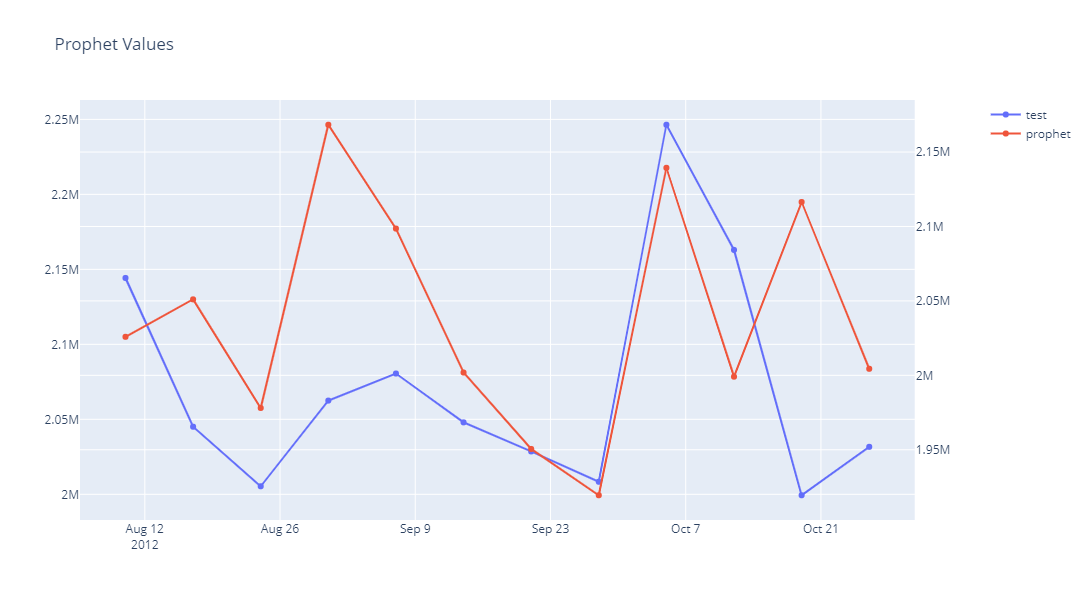

In [108]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x = x_test,y = y_test, name="test"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x = x_pp ,y = y_pp, name="prophet"),
    secondary_y=True
)

fig.update_layout(
    title_text="Prophet Values",
    width = 1000, height = 600
)

fig.show()

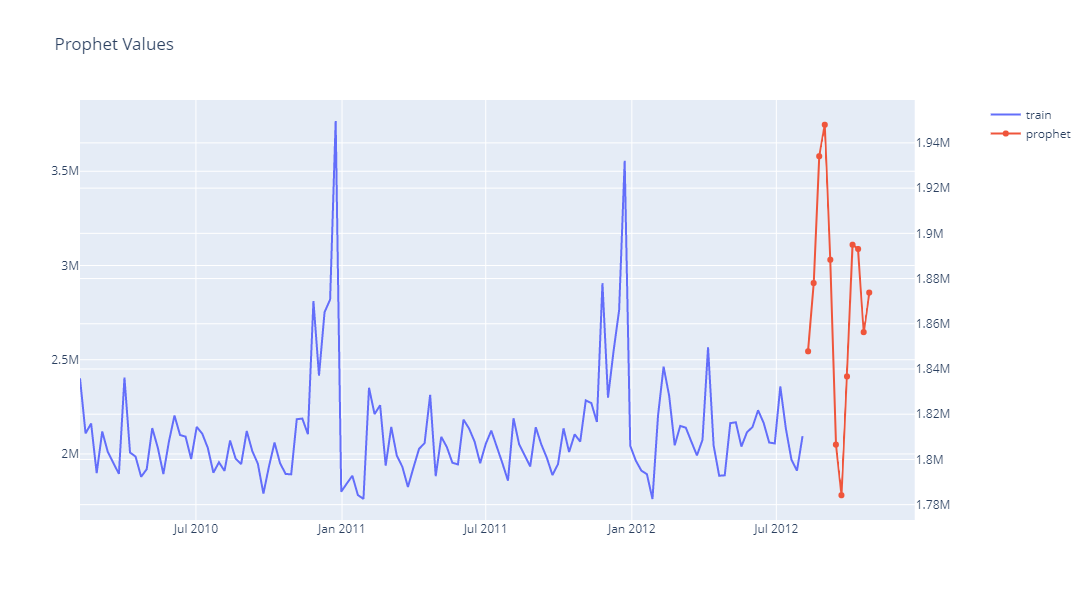

In [73]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x = x_train,y = y_train, name="train"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x = x_pp ,y = y_pp, name="prophet"),
    secondary_y=True
)

fig.update_layout(
    title_text="Prophet Values",
    width = 1000, height = 600
)

fig.show()

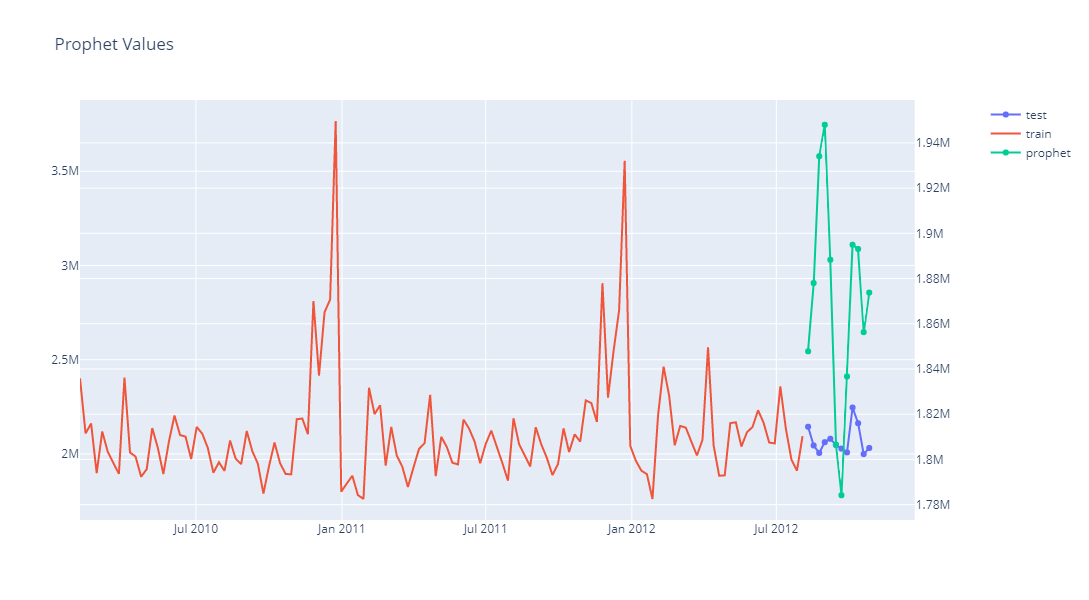

In [74]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x = x_test,y = y_test, name="test"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x = x_train,y = y_train, name="train"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x = x_pp ,y = y_pp, name="prophet"),
    secondary_y=True
)

fig.update_layout(
    title_text="Prophet Values",
    width = 1000, height = 600
)

fig.show()


Accuracy test(R2):  -793.8843692642387
Mean Absolute Error:  201761.38888207238
Mean Square Error:  46677022383.8717
Root Mean Square Error:  216048.65744519612
Mean Absolute Percentage Error:  0.09647128272186319


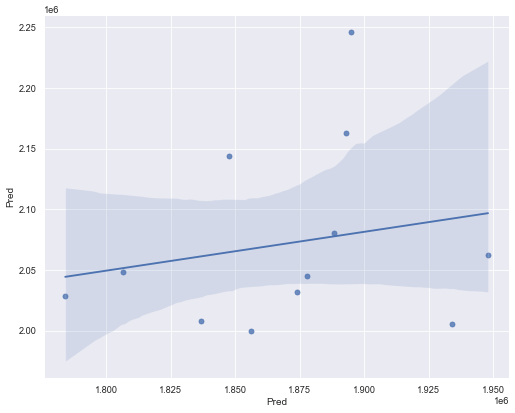

In [75]:
print('Accuracy test(R2): ', metrics.r2_score(test.Pred,pp.Pred)*100)
performance(test.Pred,pp.Pred)

## --TEST---------------------------------


In [36]:
train, test = tra_tes(m_20)

##### Construir un dataframe que almacene los años a futuro

In [37]:
forecast = pd.DataFrame({'ds':pd.to_datetime([x for x in range(2013,2017)],
                                            format='%Y'), 'y':np.nan})
forecast.tail()

,ds,y
0,2013-01-01,NaN
1,2014-01-01,NaN
2,2015-01-01,NaN
3,2016-01-01,NaN


##### forecast_train

In [38]:
# forecast_train = m.predict(train)
# forecast_final = pd.concat([forecast_train,forecast])

forecast_test = m.predict(test)
forecast_final = pd.concat([forecast_test,forecast])


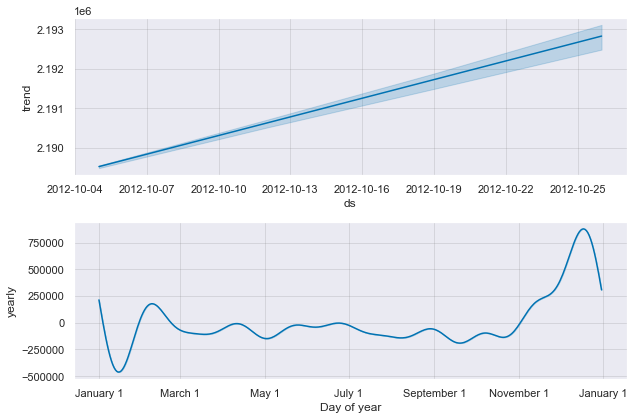

In [39]:
# m.plot_components(forecast_train);
# m.plot_components(forecast_test);


# --------------------------------------------------
m.plot_components(forecast_test);

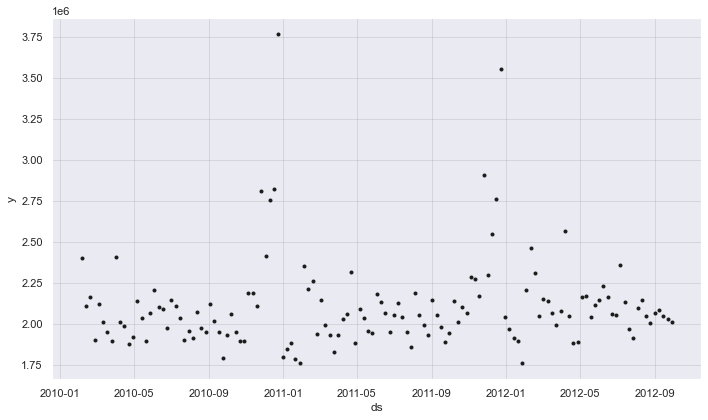

In [40]:
m.plot(forecast_final[forecast_final['ds'].dt.month==9])
plt.show();

In [41]:
# Construir futuro
future = m.make_future_dataframe(periods=12, freq='MS')

# Hacer predicciones
pp = m.predict(future)
pp.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
146,2013-05-01,"2,222,243.32","1,741,872.57","2,427,577.99","2,214,990.18","2,229,410.04","-147,509.03","-147,509.03","-147,509.03","-147,509.03","-147,509.03","-147,509.03",0.00,0.00,0.00,"2,074,734.28"
147,2013-06-01,"2,227,119.45","1,834,279.92","2,518,459.10","2,218,643.39","2,235,737.23","-33,688.06","-33,688.06","-33,688.06","-33,688.06","-33,688.06","-33,688.06",0.00,0.00,0.00,"2,193,431.39"
148,2013-07-01,"2,231,838.29","1,854,876.63","2,544,375.80","2,221,624.60","2,241,903.71","-24,640.92","-24,640.92","-24,640.92","-24,640.92","-24,640.92","-24,640.92",0.00,0.00,0.00,"2,207,197.37"
149,2013-08-01,"2,236,714.43","1,761,196.60","2,440,562.36","2,224,942.47","2,248,431.63","-132,773.86","-132,773.86","-132,773.86","-132,773.86","-132,773.86","-132,773.86",0.00,0.00,0.00,"2,103,940.56"
150,2013-09-01,"2,241,590.56","1,836,737.09","2,507,965.34","2,228,323.90","2,254,785.43","-62,897.66","-62,897.66","-62,897.66","-62,897.66","-62,897.66","-62,897.66",0.00,0.00,0.00,"2,178,692.90"


In [42]:
pp = pd.DataFrame({'Date':pp[-12:]['ds'],'Pred':pp[-12:]['yhat']})
# pp.set_index('Date', inplace= True)
# pp.index.freq = 'MS'
pp

,Date,Pred
139,2012-10-01,"2,065,905.79"
140,2012-11-01,"2,175,370.22"
141,2012-12-01,"2,600,899.87"
142,2013-01-01,"2,416,793.04"
143,2013-02-01,"2,274,559.06"
144,2013-03-01,"2,141,600.21"
145,2013-04-01,"2,161,882.36"
146,2013-05-01,"2,074,734.28"
147,2013-06-01,"2,193,431.39"
148,2013-07-01,"2,207,197.37"


In [43]:
train.columns = ['Date','Pred']
test.columns = ['Date','Pred']

x_train = train.Date
y_train  = train.Pred
x_test = test.Date
y_test  = test.Pred
x_pp = pp.Date
y_pp = pp.Pred


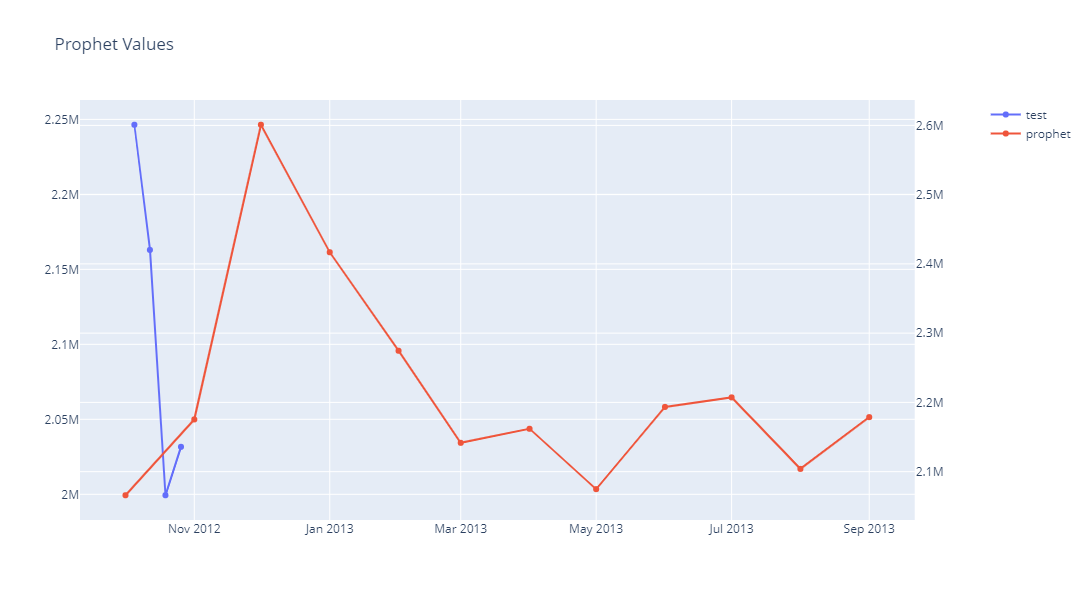

In [44]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x = x_test,y = y_test, name="test"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x = x_pp ,y = y_pp, name="prophet"),
    secondary_y=True
)

fig.update_layout(
    title_text="Prophet Values",
    width = 1000, height = 600
)

fig.show()

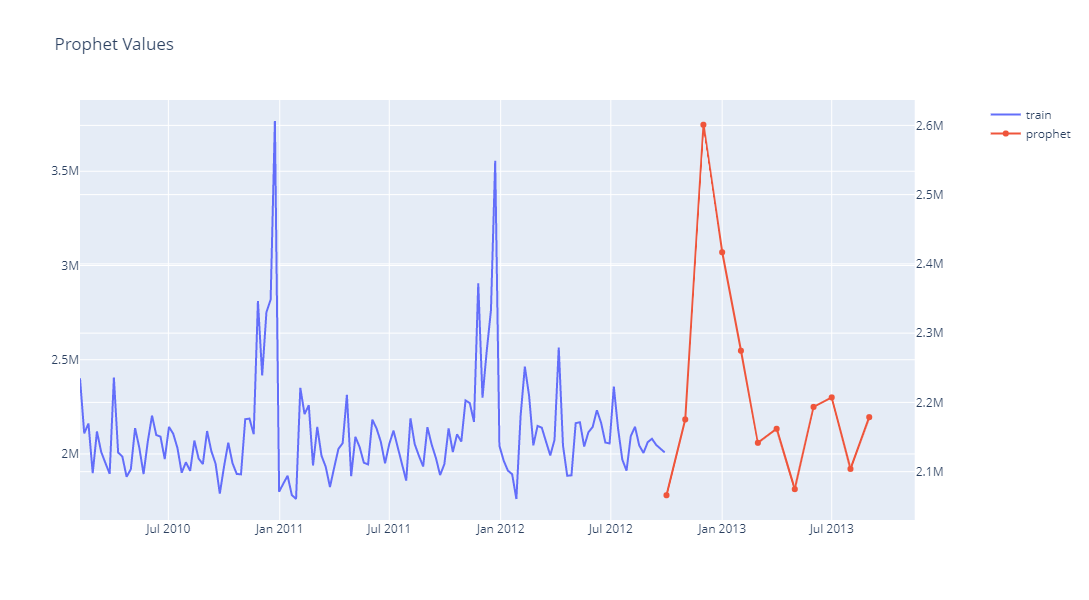

In [45]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x = x_train,y = y_train, name="train"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x = x_pp ,y = y_pp, name="prophet"),
    secondary_y=True
)

fig.update_layout(
    title_text="Prophet Values",
    width = 1000, height = 600
)

fig.show()

## -----------------------------------